## Process Flow


1.   Load Datasets
2.   **Pre-process dataset** by removing special characters, stopwords, and other noise, and convert **sentiment labels** positive & negative to numbers 1 & 0, respectively
3.   **Import GloVe Word Embedding** to build Embedding Dictionary + Use this to build Embedding Matrix for our Corpus
4. Model Training using **Deep Learning in Keras** using **LSTM Model** and analyse model performance and results

## **Setup**

In [1]:
import string
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer # ImportRegexpTokenizer to remove punctuation and tokenize
from nltk.stem import WordNetLemmatizer
from numpy import array
from keras import models
from keras.preprocessing.text import one_hot, Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

plt.style.use('ggplot')

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## **Load Data**

In [2]:
books_positive = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/books/positive.xml")
books_negative = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/books/negative.xml")

dvd_positive = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/dvd/positive.xml")
dvd_negative = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/dvd/negative.xml")

electronics_positive = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/electronics/positive.xml")
electronics_negative = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/electronics/negative.xml")

kitchen_positive = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/kitchen_%26_housewares/positive.xml")
kitchen_negative = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/kitchen_%26_housewares/negative.xml")

print(kitchen_negative['review_text'].head(20))

0     He just looks away from where the spray emits-...
1     Having read the other reviews of this product ...
2     Sometimes it sprays when she barks, most of th...
3     This item is cheaply made and I sent it back. ...
4     Initially, my dogs found the sound interesting...
5     I bought this product hoping it would solve my...
6     Our dogs didn't even notice it.  We have three...
7     Read the description carefully. It states the ...
8     I have had my Super Bark Free for 3 years. Nev...
9     Super Bark Free didn't work in the least to st...
10    The one item in your house that you really wis...
11    The design for using the DC adapter with LED B...
12    i got this fryer only yesterday i fryed some c...
13    There are a lot of theoretically good ideas th...
14    I have seen this online on other sites and in ...
15    The Corningware dish is great, my 1 star is no...
16    I was really hopeful about this product workin...
17    This is very misleading. this item is only

## **Quick Data Eval**

In [ ]:
def show_rating_graph(collection, title):
  # Must have a rating column
  ax = collection['rating'].value_counts().sort_index().plot(kind='bar', title=title)
  ax.set_xlabel('Rating')
  plt.show()

In [ ]:
#@title Books: Positive

show_rating_graph(books_positive, "Ratings of Books by Positive Reviews")

In [ ]:
#@title Books: Negative

show_rating_graph(books_negative, "Ratings of Books by Negative Reviews")

In [ ]:
#@title DVDs: Positive

show_rating_graph(dvd_positive, "Ratings of DVDs by Positive Reviews")

In [ ]:
#@title DVDs: Negative

show_rating_graph(dvd_negative, "Ratings of DVDs by Negative Reviews")

In [ ]:
#@title Electronics: Positive

show_rating_graph(electronics_positive, "Ratings of Electronics by Positive Reviews")

In [ ]:
#@title Electronics: Negative

show_rating_graph(electronics_negative, "Ratings of Electronics by Negative Reviews")

In [ ]:
#@title Kitchen and Housewares: Positive

show_rating_graph(kitchen_positive, "Ratings of kitchen and housewares by Positive Reviews")

In [ ]:
#@title Kitchen and Housewares: Negative

show_rating_graph(kitchen_negative, "Ratings of kitchen and housewares by Negative Reviews")

# **Training**

## **Step 1: Cleaning Data**

In [3]:
#@title Cleaning Data Functions

# Remove punctuations and Tokenize
def remove_punctuations_and_tokenize(input_string):
  translator = str.maketrans("", "", string.punctuation)
  formatted = input_string.translate(translator)

  # Remove undesired underscore and  slashes
  formatted = formatted.replace("_"," ").replace("/","")

  # Remove Numbers
  formatted = re.sub(r"\b[0-9]+\b\s*", "", formatted)

  # Remove Hyperlinks
  formatted = re.sub(r"https?://\S+", "", formatted)

  # Remove the HTML tags but keep their contents
  formatted = re.sub(r"<.*?>", " ", formatted)

  # Remove the alphanumerics like a389794njfhj because they dont add any value
  formatted = re.sub(r'\w*\d\w*', '', formatted)

  # Remove undesire punctuation
  return RegexpTokenizer(r'\w+').tokenize(formatted)

def tokenize_reviews(reviews):
  return [remove_punctuations_and_tokenize(review.lower()) for review in reviews]

# Remove Stopwords
def remove_stopwords(token_collection):
  # Get the list of English stopwords
  english_stopwords = stopwords.words('english')

  # Remove stopwords
  return [[word for word in tokens if word.lower() not in english_stopwords] for tokens in token_collection]

In [4]:
#@title Setting up Positive Reviews

positive_reviews = pd.concat([books_positive, dvd_positive, electronics_positive, kitchen_positive])
positive_tokenized_collection = tokenize_reviews(positive_reviews['review_text'])
positive_filtered_tokens = remove_stopwords(positive_tokenized_collection)

In [5]:
#@title Setting up Negative Reviews

negative_reviews = pd.concat([books_negative, dvd_negative, electronics_negative, kitchen_negative])
negative_tokenized_collection = tokenize_reviews(negative_reviews['review_text'])
negative_filtered_tokens = remove_stopwords(negative_tokenized_collection)

## **Step 2 (Optional): Preparing Data**

In [ ]:
#@title POS Tagging function
def pos_tag_collection(token_collection):
  return [nltk.pos_tag(tokens) for tokens in token_collection]

In [ ]:
#@title Chunking function
def chunk_collection(tagged_reviews):
  # Define chunk grammar rules
  chunk_grammar = r"""
      NP: {<DT|JJ|NN.*>+}  # Noun Phrase
      VP: {<VB.*><NP|PP>*}  # Verb Phrase
  """
  chunk_parser = nltk.RegexpParser(chunk_grammar)
  return [chunk_parser.parse(tagged_review) for tagged_review in tagged_reviews]
  # return [nltk.chunk.ne_chunk(tagged_review) for tagged_review in tagged_reviews]

In [ ]:
#@title Lemmatization function
def lemmatize_collection(tagged_collection):
  lemmatizer = WordNetLemmatizer()
  lemmatized_collection = []

  for tagged_phrase in tagged_collection:
    phrase = []

    for token, tag in tagged_phrase:
      pos = 'n'

      if tag.startswith("NN"):
        pos = 'n'
      elif tag.startswith('VB'):
        pos = 'v'
      elif tag.startswith('RB'):
        pos = 'r'
      elif tag.startswith('JJ'):
        pos = 'a'

      phrase.append(lemmatizer.lemmatize(token, pos))

    lemmatized_collection.append(phrase)

  return lemmatized_collection

In [ ]:
#@title POS Tagging for positive reviews
tagged_positives = pos_tag_collection(positive_filtered_tokens)

In [ ]:
for tagged_positive in tagged_positives[:10]:
  for token, tag in tagged_positive:
    print(f"{token}: {tag}")

In [ ]:
#@title Chunking for positive reviews
chunked_positives = chunk_collection(tagged_positives)

In [ ]:
!pip install svgling

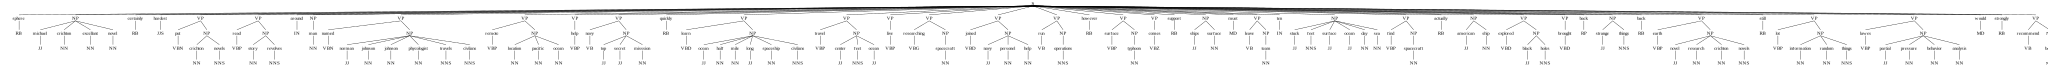

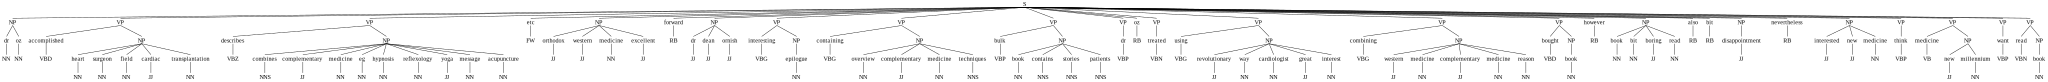

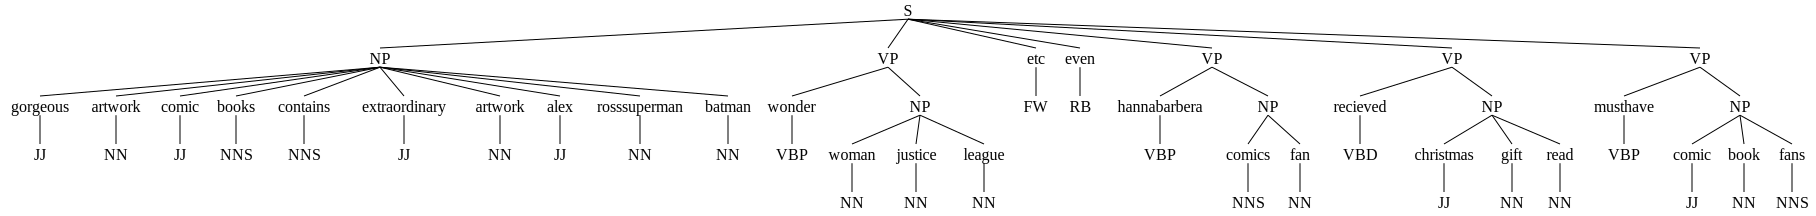

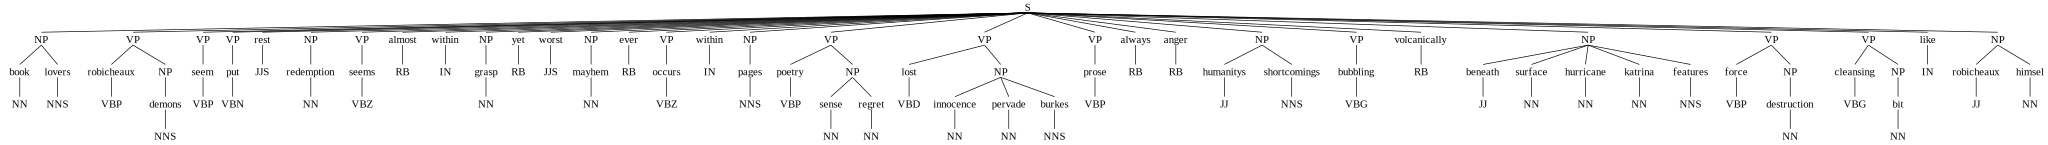

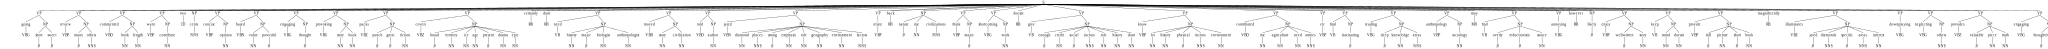

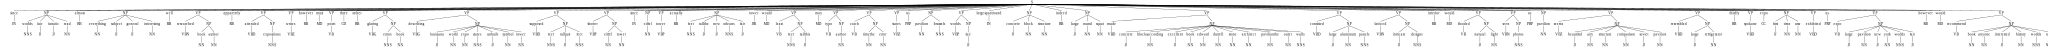

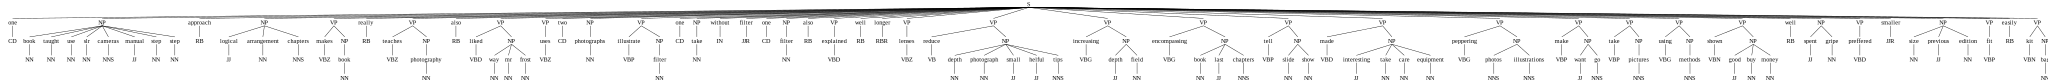

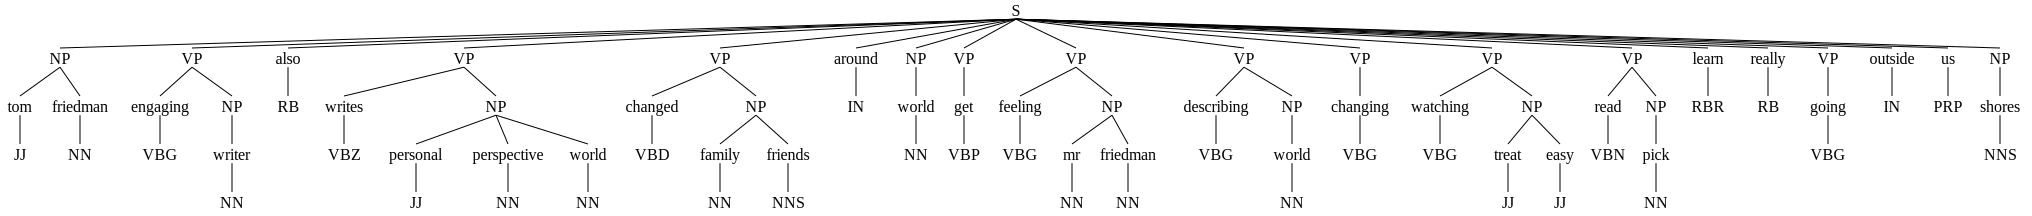

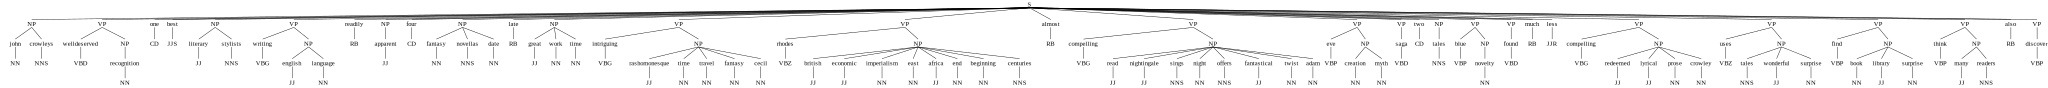

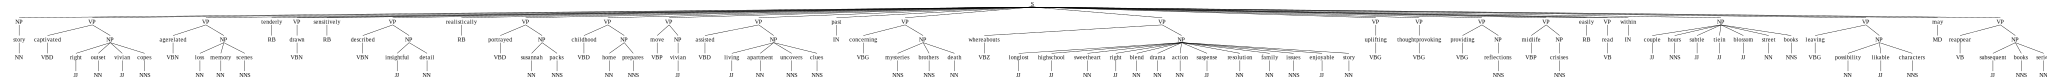

In [ ]:
import IPython.display

for tagged_positive in chunked_positives[:10]:
  IPython.display.display(tagged_positive)

In [ ]:
#@title Lemmatization for positive reviews
lemmatized_positives = lemmatize_collection(tagged_positives)

In [ ]:
lemmatized_positives[0]

['sphere',
 'michael',
 'crichton',
 'excellant',
 'novel',
 'certainly',
 'hard',
 'put',
 'crichton',
 'novel',
 'read',
 'story',
 'revolves',
 'around',
 'man',
 'name',
 'norman',
 'johnson',
 'johnson',
 'phycologist',
 'travel',
 'civilans',
 'remote',
 'location',
 'pacific',
 'ocean',
 'help',
 'navy',
 'top',
 'secret',
 'misssion',
 'quickly',
 'learn',
 'ocean',
 'half',
 'mile',
 'long',
 'spaceship',
 'civilans',
 'travel',
 'center',
 'foot',
 'ocean',
 'live',
 'research',
 'spacecraft',
 'join',
 'navy',
 'personel',
 'help',
 'run',
 'operation',
 'however',
 'surface',
 'typhoon',
 'come',
 'support',
 'ships',
 'surface',
 'must',
 'leave',
 'team',
 'ten',
 'stuck',
 'foot',
 'surface',
 'ocean',
 'day',
 'sea',
 'find',
 'spacecraft',
 'actually',
 'american',
 'ship',
 'explore',
 'black',
 'hole',
 'bring',
 'back',
 'strange',
 'thing',
 'back',
 'earth',
 'novel',
 'research',
 'crichton',
 'novel',
 'still',
 'lot',
 'information',
 'random',
 'thing',
 'lawe

In [ ]:
#@title POS Tagging and Chunking for negative reviews
tagged_positives = pos_tag_collection(negative_filtered_tokens)
chunked_positives = chunk_collection(tagged_positives)

In [ ]:
for tagged_positive in tagged_positives[:10]:
  for token, tag in tagged_positive:
    print(f"{token}: {tag}")

book: NN
horrible: JJ
possible: JJ
rate: NN
lower: RBR
one: CD
star: NN
would: MD
avid: VB
reader: NN
picked: VBN
book: NN
mom: NN
gotten: JJ
friend: VBP
read: JJ
half: NN
suffering: VBG
headache: NN
entire: JJ
time: NN
got: VBD
part: NN
relationship: NN
year: NN
old: JJ
boy: NN
year: NN
old: JJ
man: NN
lit: VBD
book: NN
fire: NN
one: CD
less: JJR
copy: NN
worlddont: NN
waste: NN
money: NN
wish: JJ
time: NN
spent: VBN
reading: NN
book: NN
back: RB
could: MD
use: VB
better: JJR
purposes: NNS
book: NN
wasted: VBD
life: NN
like: IN
use: NN
amazon: NN
reviews: NNS
purchasing: VBG
books: NNS
especially: RB
alert: VBP
dissenting: VBG
perceptions: NNS
higly: RB
rated: VBN
items: NNS
usually: RB
disuades: VBZ
selection: NN
offer: NN
review: NN
seriously: RB
questions: NNS
popularity: NN
work: NN
found: VBD
smug: RB
selfserving: VBG
selfindulgent: NN
written: VBN
person: NN
little: JJ
empathy: JJ
especially: RB
people: NNS
castigates: VBZ
example: NN
portrayal: JJ
family: NN
therapist: NN
seems

## **Step 3: Embedding Data**

In [6]:
#@title Combine positive and negative reviews with labels
reviews = positive_filtered_tokens + negative_filtered_tokens
labels = np.array([1] * len(positive_filtered_tokens) + [0] * len(negative_filtered_tokens))

In [7]:
#@title Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=42)

In [8]:
#@title Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [9]:
#@title Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

39085

In [10]:
#@title Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [11]:
#@title Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/Colab Notebooks/dataset/glove_word_embeddings.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [12]:
#@title Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

In [13]:
embedding_matrix.shape

(39085, 100)

## **Step 4: Model Training**

In [14]:
#@title Import LSTM from keras
from keras.layers import LSTM

In [15]:
#@title Use Sequential for Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [16]:
#@title Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          3908500   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 4,025,877
Trainable params: 117,377
Non-trainable params: 3,908,500
_________________________________________________________________
None


In [17]:
#@title Model Training with 128 batch size and 12 epochs

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=12, verbose=1, validation_split=0.2)

Epoch 1/12
40/40 [==============================] - 18s 393ms/step - loss: 0.6866 - acc: 0.5264 - val_loss: 0.6777 - val_acc: 0.5859
Epoch 2/12
40/40 [==============================] - 14s 358ms/step - loss: 0.6079 - acc: 0.6812 - val_loss: 0.6196 - val_acc: 0.6711
Epoch 3/12
40/40 [==============================] - 14s 360ms/step - loss: 0.5873 - acc: 0.7111 - val_loss: 0.5693 - val_acc: 0.7195
Epoch 4/12
40/40 [==============================] - 17s 436ms/step - loss: 0.5543 - acc: 0.7437 - val_loss: 0.5531 - val_acc: 0.7336
Epoch 5/12
40/40 [==============================] - 16s 401ms/step - loss: 0.5313 - acc: 0.7508 - val_loss: 0.5432 - val_acc: 0.7484
Epoch 6/12
40/40 [==============================] - 14s 346ms/step - loss: 0.5009 - acc: 0.7721 - val_loss: 0.5417 - val_acc: 0.7055
Epoch 7/12
40/40 [==============================] - 14s 360ms/step - loss: 0.4935 - acc: 0.7771 - val_loss: 0.5059 - val_acc: 0.7648
Epoch 8/12
40/40 [==============================] - 14s 356ms/step - 

In [18]:
#@title Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

50/50 [==============================] - 6s 104ms/step - loss: 0.4699 - acc: 0.7794


In [19]:
#@title Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.46990057826042175
Test Accuracy: 0.7793750166893005


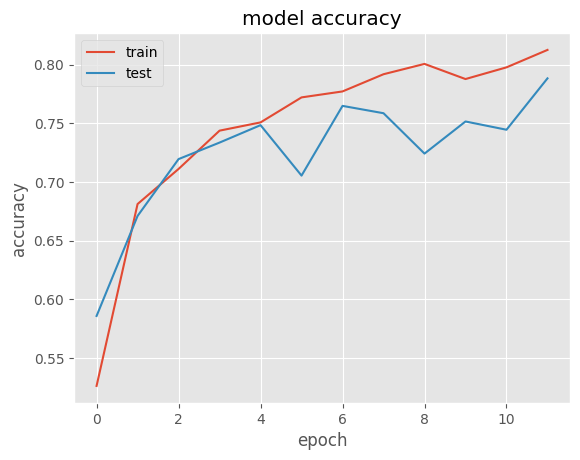

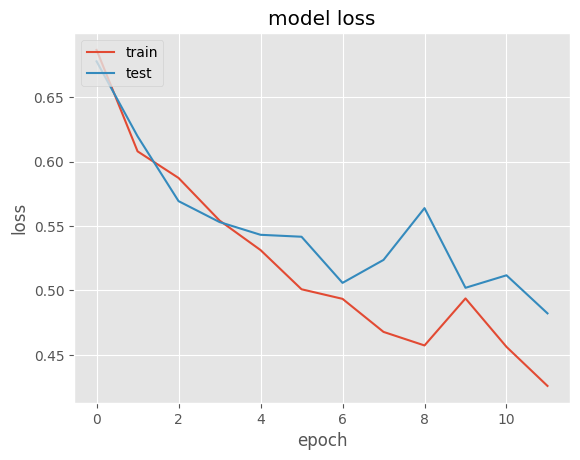

In [20]:
#@title Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [21]:
round(score[1], 3)

0.779

In [22]:
#@title Saving the model as a keras file for possible use later

lstm_model.save("lstm_model.keras")

## **Step 5: Test Model**

In [23]:
#@title Load Model
loaded_model = models.load_model("lstm_model.keras")

# List of sample reviews
sample_reviews = [
    "This movie was amazing! I loved every moment of it.",
    "The product arrived damaged and the quality is terrible.",
    "The book was okay, but not as good as I expected.",
    "This restaurant has the best food ever. Highly recommended!",
    "I'm extremely disappointed with this purchase. Waste of money."
]

In [24]:
#@title Tokenize and pad sequences for the sample reviews
untested_tokenized_collection = tokenize_reviews(sample_reviews)
untested_filtered_tokens = remove_stopwords(untested_tokenized_collection)

In [25]:
#@title Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(untested_filtered_tokens)

In [26]:
#@title Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [27]:
#@title Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 1s 549ms/step


array([[0.90573764],
       [0.04985693],
       [0.6641579 ],
       [0.9059326 ],
       [0.0441691 ]], dtype=float32)